# TrackerLab Notebook Version 1.0

This is the Notebook Version of the TrackerLab for exporting images and testing

### Required packages:

In [1]:
import numpy as np
pi = np.pi
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib

import fnmatch
import sys, os

from nptdms import TdmsFile # this library contains the actual TDMS loading parts

from matplotlib import colors
import pickle
from scipy import ndimage

import skimage
#from skimage import io
from skimage import morphology    

import pandas as pd
import trackpy as tp

In [2]:
fdir = 'E:/' # set the "Select Files..." dialog start directory to the notebook directory
def openFilesDialog(fdir):
    from PyQt5.QtWidgets import QApplication,QFileDialog
    app = QApplication([dir])
    files = QFileDialog.getOpenFileNames(None, "Select Files...", fdir, filter='TDMS Files (*.tdms);;All Files (*)')
    return files[0]

def loadTDMSImages(file):
    global exposure, dimx, dimy, binning
    tdms_file = TdmsFile(file)
    p=tdms_file.object().properties   
    dimx=int(p['dimx'])  
    dimy=int(p['dimy'])
    frames=int(p['dimz'])
    binning=int(p['binning'])
    exposure=float(p['exposure'])
    images=tdms_file.channel_data('Image','Image')
    return images.reshape(frames,dimx,dimy)

## Select files to process

In [3]:
files = openFilesDialog(fdir)
fdir = os.path.dirname(files[0]) # set the dialog start directory to the selected directory
print('Selected Files:')
for file in files:
    print(file)

IndexError: list index out of range

In [ ]:
# Trajectory
#f = pd.read_pickle('E:/180227_A-Beta_Fibril_ThT_Trapping/Set4_006_features.pkl')
#t = tp.link_df(f, search_range=25, memory=3)
#df = tp.filter_stubs(t, 10)

##  Select color map

In [77]:
try:
    cmap = pickle.load(open('colormaps/cmap_tht_black.pkl', 'rb'))
    #cmap = pickle.load(open('colormaps/cmap_white_blue.pkl', 'rb'))
    cmap = 'gray'
    #cmap = 'viridis'
except Exception as e:
    cmap = 'gray' # default
    print(e, 'Using the default color map.')

[Errno 2] No such file or directory: 'colormaps/cmap_tht_black.pkl' Using the default color map.


## Here, you can test color scale, overlay, ...

In [73]:
# find the first *_movie.tdms in the list of files and load it 
i = [i for i, file in enumerate(files) if fnmatch.fnmatch(file, '*_movie.tdms')][0]
#i = 0
images = loadTDMSImages(files[i])

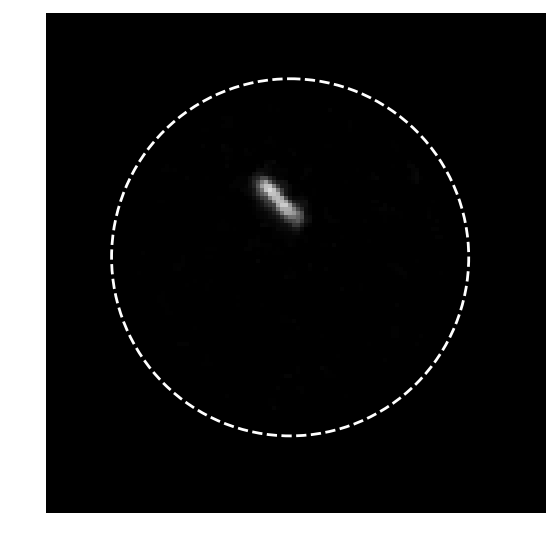

In [75]:
k = 637
image = images[k]

# color scale 
autoscale = False
vmin = 200
vmax = 1500

# filters
medianfilter = True
median = 3
if median:
    image = ndimage.median_filter(image, median) 

# mask
mask = True
if mask:
    x0 = 61; y0 = 61
    radius = 39
    xx, yy= np.meshgrid(np.arange(0, dimx, 1), np.arange(0, dimy, 1))
    maskimage = (((xx - x0)**2 + (yy - y0)**2) < (radius)**2).astype(int)
    image = image*maskimage

    
# region of interest
roi = False
roi_x = 35
roi_y = 30
roi_w = 45
roi_h = 35

# overlay
scalebar = False
um2px = 0.0577*binning # µm/px
if scalebar:
    if roi:
        sb_um = 1 # µm
        sb_x = 0.75*roi_w
        sb_y = 0.80*roi_h
    else:
        sb_um = 3 # µm 
        sb_x = 0.825*dimx
        sb_y = 0.825*dimy
    sb_px = int(np.round(sb_um/um2px))


fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(1,1,1)

if autoscale:
    ax.imshow(image, cmap=cmap)
else:
    ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
if scalebar:
    ax.text(sb_x, sb_y, str(sb_um) + ' µm', va='center',ha='center',color='k',fontsize=20)
    ax.plot([sb_x-sb_px/2, sb_x+sb_px/2], [1.075*sb_y, 1.075*sb_y], 'k', lw=5);

if roi:
    ax.set_xlim(roi_x, roi_x+roi_w)
    ax.set_ylim(roi_y+roi_h, roi_y)

#ax.text(425, 50, 'On', va='center',ha='left',color='w',fontsize=20)
ri = 45
ax.add_patch(plt.Circle((x0, y0), radius=ri, color='w', ls='--', lw=2, fill=False))
#ro = 50
#ax.add_patch(plt.Circle((x0, y0), radius=ro, color='w', ls='-', lw=2, fill=False))

fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
plt.axis('off')
#ax.axes.get_xaxis().set_ticks([])
#ax.axes.get_yaxis().set_ticks([])
#for axis in ['top','bottom','left','right']:
#    ax.spines[axis].set_linewidth(3)
    
# Trajectory
#ax.plot(f['x'].tolist()[0:k], f['y'].tolist()[0:k], 'w', alpha=0.25)

export = False
if export:
    plt.savefig(files[i].replace('_movie.tdms','pre-processed.png'), dpi=300)

## Tracking

In [76]:
spots = pd.DataFrame()
threshold = 600
minArea = 25 
maxArea = 250
thresholdImage = (image > threshold).astype(int) # relative threshold
labelImage = skimage.measure.label(thresholdImage)
regions = skimage.measure.regionprops(label_image=labelImage, intensity_image=image) # http://scikit-image.org/docs/dev/api/skimage.measure.html
for region in regions:
    # area filter first
    if region.area < minArea or region.area > maxArea:   # do not add feature
        continue
    spots = spots.append([{'y': region.centroid[0], 
                           'x': region.centroid[1],
                           'orientation': region.orientation,
                           'minor_axis_length': region.minor_axis_length,
                           'major_axis_length': region.major_axis_length,
                           'area': region.area,
                           'max_intensity': region.max_intensity,
                           'frame': i,}]) 
    
df = spots

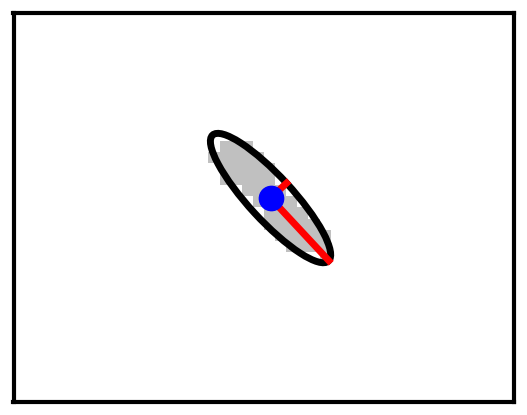

In [70]:
from matplotlib.patches import Ellipse

fig = plt.figure(figsize=(5,5), dpi=100)
ax = fig.add_subplot(1,1,1)

fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
#plt.axis('off')
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)


ax.imshow(thresholdImage, cmap='gray_r', alpha=0.25)

if scalebar:
    ax.text(sb_x, sb_y, str(sb_um) + ' µm', va='center',ha='center',color='w',fontsize=20)
    ax.plot([sb_x-sb_px/2, sb_x+sb_px/2], [1.075*sb_y, 1.075*sb_y], 'w', lw=5);

# Trap Overlay
ri = 45
x0 = 61; y0 = 61
ax.add_patch(plt.Circle((x0, y0), radius=ri, color='w', ls='--', lw=2, fill=False))

# Tracker Overlay
if True:
    x0 = df[df['frame']==i].x.item()
    y0 = df[df['frame']==i].y.item()
    # plot major and minor axis
    orientation = df[df['frame']==i].orientation.item()
    a = df[df['frame']==i].major_axis_length.item()
    b = df[df['frame']==i].minor_axis_length.item()
    x1 = x0 + np.cos(orientation)*0.5*df[df['frame']==i].major_axis_length.item()
    y1 = y0 - np.sin(orientation)*0.5*df[df['frame']==i].major_axis_length.item()
    x2 = x0 - np.sin(orientation)*0.5*df[df['frame']==i].minor_axis_length.item()
    y2 = y0 - np.cos(orientation)*0.5*df[df['frame']==i].minor_axis_length.item()
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=5)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=5)
    ax.plot(x0, y0, '.b', markersize=35)
    ellipse = Ellipse((x0, y0), a, b, -orientation*57.7, color='k', lw=5, ls='-', fill=False)
    ax.add_patch(ellipse)

if roi:
    ax.set_xlim(roi_x, roi_x+roi_w)
    ax.set_ylim(roi_y+roi_h, roi_y)

if export:
    plt.savefig(files[i].replace('_movie.tdms','_threshold.png'), dpi=300)

In [8]:
from skimage.feature import blob_log, blob_dog

In [71]:
images = loadTDMSImages('E:/181002_Au_NP_250nm_Au_Film/0800uW_001_movie.tdms')

In [72]:
image = images[0]
mlist = blob_dog(image/image.max(), max_sigma=10, threshold=15/100)

In [73]:
mlist

array([[ 204.    ,  201.    ,    6.5536],
       [  23.    ,  190.    ,    6.5536]])

In [74]:
j = 0
xx, yy= np.meshgrid(np.arange(0, image.shape[0], 1), np.arange(0, image.shape[1], 1))
mask = (((xx - mlist[j, 1])**2 + (yy - mlist[j, 0])**2) < (mlist[j, 2]*np.sqrt(2))**2).astype(int)

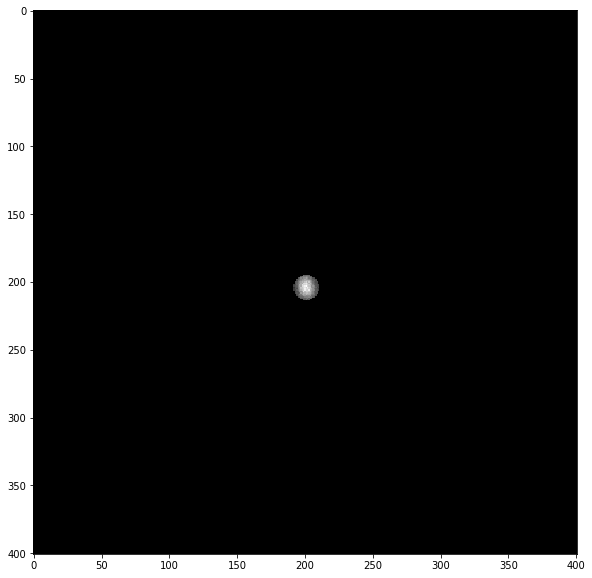

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.imshow(image*mask, cmap='gray');

In [76]:
image[mask==1].max()

2111

In [80]:
    features = pd.DataFrame()
    X,Y = np.meshgrid(np.arange(0, image.shape[0], 1), np.arange(0, image.shape[1], 1))
    if mlist.size > 0:
        for j in range(mlist.shape[0]):
            mask = (((X - mlist[j, 1])**2 + (Y - mlist[j, 0])**2) < (mlist[j, 2]*np.sqrt(2))**2).astype(int)
            features = features.append([{'y': mlist[j, 0], 
                                         'x': mlist[j, 1],
                                         'max_intensity': image[mask==1].max(),
									     #'max_intensity': image[int(mlist[j, 0]), int(mlist[j, 1])].max(),
									     'frame': i,}])  
            print(image[mask==1].max())

2111
2406


In [78]:
features

,frame,max_intensity,x,y
0,1,2111,201.0,204.0
0,1,2406,190.0,23.0
